In [1]:
!pip install pythainlp

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

C:\Users\Gumpun\AppData\Local\Temp\ipykernel_15084\4157868343.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
pos_text = ("C:/Users/Gumpun/Sentiment-Analysis-System-for-Consumer-Products/DataReviewProductThai/Positive.csv")
neg_text = ("C:/Users/Gumpun/Sentiment-Analysis-System-for-Consumer-Products/DataReviewProductThai/Negative.csv")
neu_text = ("C:/Users/Gumpun/Sentiment-Analysis-System-for-Consumer-Products/DataReviewProductThai/Neutrally.csv")

In [4]:
pos_df = pd.read_csv(pos_text, delimiter=',', encoding='utf-8').dropna()
neg_df = pd.read_csv(neg_text, delimiter=',', encoding='utf-8').dropna()
neu_df = pd.read_csv(neu_text, delimiter=',', encoding='utf-8').dropna()

data = pd.concat([pos_df, neg_df, neu_df])
data.sample(100)

,User,Message,Sentiment
1005,กุ้ง เ.,กางเกงขาดก็ส่งมาให้น่าจะดูก่อนค่อยส่งมาแต่ถ้าถ...,Neutrally
6,ณัฐวรรธน์ ก.,สั่งขาสั้นได้ขายาว ไม่ตรงสเปคตามที่สั่งครับ,Negative
236,Smile J.,กางเกงใส่สบายๆ ไม่รู้เรียกว่าผ้าอะไร แต่กางเกง...,Neutrally
1170,Theerpat P.,พังเร็วมาก,Negative
154,ชีวาวิชช์ ฉ.,สินค้าจรงตามปก สวยงาม ถูกใจ ตัดเย็บเรียบร้อยดีมาก,Positive
...,...,...,...
912,Somchai P.,เสียงพอใช้ได้ เวลาฟังเพลง แต่เวลาพูดคุยแล้วเสี...,Neutrally
624,อุ๊..นะคะ.,ผ้าดีมากค่ะ,Neutrally
922,No N.,เนื้อผ้าสมราคาค่ะ,Neutrally
1407,อ***.,การจัดส่งถือว่ารวดเร็ว แก้วน้ำมีกันกระแทกก้อโอ...,Neutrally


In [5]:
from pythainlp.tokenize import word_tokenize

In [6]:
# สร้างฟังก์ชันสำหรับการลบอักขระที่ซ้ำกันในแต่ละคำเท่านั้น
def remove_duplicate_chars(text):
    if isinstance(text, str):  # ตรวจสอบว่าข้อความไม่ใช่ NaN
        unique_words = []
        words = word_tokenize(text)
        for word in words:
            unique_word = ''
            for char in word:
                if char not in unique_word:
                    unique_word += char
            unique_words.append(unique_word)
        return ' '.join(unique_words)
    else:
        return text  # ส่งค่า NaN กลับหากเป็น NaN

# ใช้ฟังก์ชัน `remove_duplicate_chars` เพื่อ Tokenize และลบคำที่ซ้ำ
data['Message'] = data['Message'].apply(remove_duplicate_chars)
data.sample(10)

,User,Message,Sentiment
194,ปูแก้ว,ผ้า ที่ ยอดเี่ม สำหรับ ความ สบาย อัน สมบูรณ์ ...,Positive
12,apichai A.,สินค้า ตรง ตามที่ สั่ง แต่วา ยางืด ที่ เอว ดูเ...,Neutrally
1048,คุณรัชพล อ.,สภาพ สินค้า ตาม ราค ดู ไม่คอย แข็งร เหมือน รุ่...,Positive
717,0***4,คุณภาพดี สินค้า ตรง ปก ใส่ สบาย เท้า ส่ง ตรงเว...,Positive
255,นายพันธ์ศักดิ์กรตเรี่ยม,ส่ง เร็ว ดีแต่ ก็ ดู บอาง ไป หน่อย ครับ เย็บ...,Neutrally
948,*******048,เล็ก ไป นิดห่อย,Neutrally
542,ธ***.,ดี ผ้า นิ่ม ราค ดี,Positive
225,8***4,เสื้อ สีัน สดใ ผ้า ค่อนข้าง บาง ใส่ เย็นสบา เน...,Positive
691,sirinan,จัดส่ง รวดเ็ แพ คอ ย่าง ดี สี สวย ตามที่...,Positive
1169,โสภณ​ ก.,ตัดเย็บ แย่จัง งาน ดู ไม่ ดี แต่ สำหรับ คน...,Neutrally


In [7]:
Message = data['Message'].values
Sentiment = data['Sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(Sentiment)
print("Encoded labels:", encoded_labels)
print("Mapping of encoded labels to original labels:")

for label, original_label in enumerate(encoder.classes_):
    print(f"{label}: {original_label}")

Encoded labels: [2 2 2 ... 1 1 1]
Mapping of encoded labels to original labels:
0: Negative
1: Neutrally
2: Positive


In [8]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
train_sentences, test_sentences, train_labels, test_labels = train_test_split(Message, encoded_labels, stratify=encoded_labels, test_size=0.1, random_state=42)

In [9]:
#ทำส่วนของ TF-IDF
val_size = int(len(test_sentences)/2)
train = list(train_sentences)[:(len(train_sentences)-val_size)]
val = list(train_sentences)[(len(train_sentences)-val_size):]
test = list(test_sentences)

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

#ใช้ชุดเทรน ทำ vectorizer
tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = torch.tensor(tfidfX_train.toarray())

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = torch.tensor(tfidfX_val.toarray())

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = torch.tensor(tfidfX_test.toarray())

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: torch.Size([3816, 1000])
TF-IDF test shape: torch.Size([450, 1000])
TF-IDF val shape: torch.Size([225, 1000])


In [10]:
#โค้ดที่ให้มาน่าจะใช้สำหรับการแปลงป้ายกำกับของชุดข้อมูลการจำแนกประเภทข้อความให้อยู่ในรูปแบบของ PyTorch
Y_train = torch.squeeze(torch.tensor(list(train_labels[:(len(train_sentences)-val_size)])).float())
Y_val = torch.squeeze(torch.tensor(train_labels[(len(train_sentences)-val_size):]).float())
Y_test = torch.squeeze(torch.tensor(test_labels).float())

print("Y train shape:", Y_train.shape)
print("Y test shape:", Y_val.shape)
print("Y shape:", Y_test.shape)

Y train shape: torch.Size([3816])
Y test shape: torch.Size([225])
Y shape: torch.Size([450])


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [12]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FFNN, self).__init__()

        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [13]:
#กำหนดและสร้างโมเดล Feedforward Neural Network
# Define the number of classes
num_classes = 3

# Define the input and hidden dimensions
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 1024
hidden_dim_2 = 512
output_dim = num_classes

# Define the model with the appropriate output dimension
first_model = FFNN(input_dim, hidden_dim_1, hidden_dim_2, num_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(first_model.parameters(), lr=0.1e-4, weight_decay=1e-3)

# Transfer the model to the GPU if available
first_model.to(device)

FFNN(
  (layer_1): Linear(in_features=1000, out_features=1024, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=3, bias=True)
)

In [14]:
from tqdm import tqdm

# Define the function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float()
    acc = correct.sum() / len(correct)
    return acc

# Define batch size
batch_size = 16

# Epochs
num_epochs = 100

# Split train dataset into mini-batches
X_train_mini_batches = torch.split(tfidfX_train, batch_size)
Y_train_mini_batches = torch.split(Y_train, batch_size)

# Initialize lists to store losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
min_loss = float('inf')

# Start training
for epoch in range(num_epochs):
    print('epoch', epoch)
    epoch_loss = 0
    epoch_accuracy = 0

    for X_train_mini_batch, Y_train_mini_batch in tqdm(zip(X_train_mini_batches, Y_train_mini_batches)):
        X_train_mini_batch = X_train_mini_batch.to(device)
        Y_train_mini_batch = Y_train_mini_batch.to(device)

        # Forward pass to get output
        train_prediction = first_model(X_train_mini_batch.float())

        # Calculate Loss
        train_loss = criterion(train_prediction, Y_train_mini_batch.long())  # Convert Y_train_mini_batch to long type

        # Clearing up accumulated gradients
        optimizer.zero_grad()

        # Getting gradients
        train_loss.backward()

        # Updating parameters
        optimizer.step()

        # Add each mini batch's loss
        epoch_loss += train_loss.item()

        # Add each mini batch's accuracy
        epoch_accuracy += calculate_accuracy(Y_train_mini_batch, train_prediction)

    # Print loss and accuracy for some epochs
    if epoch % 1 == 0:
        tfidfX_val = tfidfX_val.to(device)
        Y_val = Y_val.to(device)

        # Forward pass to get output
        val_prediction = first_model(tfidfX_val.float())

        # Calculate Loss
        val_loss = criterion(val_prediction, Y_val.long())  # Convert Y_val to long type

        epoch_loss /= len(X_train_mini_batches)
        epoch_accuracy /= len(X_train_mini_batches)
        val_losses.append(val_loss.item())
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        val_accuracies.append(calculate_accuracy(Y_val, val_prediction))

        if val_loss.item() < min_loss:
            min_loss = val_loss.item()
            torch.save(first_model.state_dict(), 'best_model.pt')
            print('save best_model...')

        print("Epoch:", epoch, "\n"
              "Train_loss:", round(epoch_loss, 4), "Train Accuracy:", round(epoch_accuracy.item(), 4), "\n"
              "Validation_loss:  ", round(val_loss.item(), 4), "Validation Accuracy:  ", round(val_accuracies[-1].item(), 4), "\n")


epoch 0


239it [00:00, 383.63it/s]


save best_model...
Epoch: 0 
Train_loss: 1.0985 Train Accuracy: 0.3305 
Validation_loss:   1.0975 Validation Accuracy:   0.3867 

epoch 1


239it [00:00, 501.84it/s]


save best_model...
Epoch: 1 
Train_loss: 1.0981 Train Accuracy: 0.3305 
Validation_loss:   1.0972 Validation Accuracy:   0.3867 

epoch 2


239it [00:00, 517.32it/s]


save best_model...
Epoch: 2 
Train_loss: 1.0977 Train Accuracy: 0.3321 
Validation_loss:   1.0968 Validation Accuracy:   0.3911 

epoch 3


239it [00:00, 498.95it/s]


save best_model...
Epoch: 3 
Train_loss: 1.0972 Train Accuracy: 0.3611 
Validation_loss:   1.0962 Validation Accuracy:   0.44 

epoch 4


239it [00:00, 482.83it/s]


save best_model...
Epoch: 4 
Train_loss: 1.0964 Train Accuracy: 0.482 
Validation_loss:   1.0953 Validation Accuracy:   0.5778 

epoch 5


239it [00:00, 495.85it/s]


save best_model...
Epoch: 5 
Train_loss: 1.0952 Train Accuracy: 0.6114 
Validation_loss:   1.0938 Validation Accuracy:   0.6667 

epoch 6


239it [00:00, 466.80it/s]


save best_model...
Epoch: 6 
Train_loss: 1.0932 Train Accuracy: 0.6525 
Validation_loss:   1.0913 Validation Accuracy:   0.6933 

epoch 7


239it [00:00, 519.57it/s]


save best_model...
Epoch: 7 
Train_loss: 1.0902 Train Accuracy: 0.6553 
Validation_loss:   1.0874 Validation Accuracy:   0.72 

epoch 8


239it [00:00, 527.60it/s]


save best_model...
Epoch: 8 
Train_loss: 1.0855 Train Accuracy: 0.6566 
Validation_loss:   1.0814 Validation Accuracy:   0.7156 

epoch 9


239it [00:00, 522.98it/s]


save best_model...
Epoch: 9 
Train_loss: 1.0786 Train Accuracy: 0.6498 
Validation_loss:   1.0726 Validation Accuracy:   0.6933 

epoch 10


239it [00:00, 524.12it/s]


save best_model...
Epoch: 10 
Train_loss: 1.0688 Train Accuracy: 0.648 
Validation_loss:   1.0605 Validation Accuracy:   0.68 

epoch 11


239it [00:00, 520.89it/s]


save best_model...
Epoch: 11 
Train_loss: 1.0558 Train Accuracy: 0.6362 
Validation_loss:   1.045 Validation Accuracy:   0.6756 

epoch 12


239it [00:00, 522.98it/s]


save best_model...
Epoch: 12 
Train_loss: 1.0401 Train Accuracy: 0.6355 
Validation_loss:   1.027 Validation Accuracy:   0.68 

epoch 13


239it [00:00, 526.43it/s]


save best_model...
Epoch: 13 
Train_loss: 1.0229 Train Accuracy: 0.6349 
Validation_loss:   1.008 Validation Accuracy:   0.68 

epoch 14


239it [00:00, 479.92it/s]


save best_model...
Epoch: 14 
Train_loss: 1.0058 Train Accuracy: 0.6328 
Validation_loss:   0.9899 Validation Accuracy:   0.6756 

epoch 15


239it [00:00, 482.83it/s]


save best_model...
Epoch: 15 
Train_loss: 0.9899 Train Accuracy: 0.6334 
Validation_loss:   0.9736 Validation Accuracy:   0.68 

epoch 16


239it [00:00, 464.98it/s]


save best_model...
Epoch: 16 
Train_loss: 0.9761 Train Accuracy: 0.6336 
Validation_loss:   0.9597 Validation Accuracy:   0.6756 

epoch 17


239it [00:00, 477.08it/s]


save best_model...
Epoch: 17 
Train_loss: 0.9643 Train Accuracy: 0.637 
Validation_loss:   0.9482 Validation Accuracy:   0.6667 

epoch 18


239it [00:00, 478.93it/s]


save best_model...
Epoch: 18 
Train_loss: 0.9545 Train Accuracy: 0.6399 
Validation_loss:   0.9386 Validation Accuracy:   0.6622 

epoch 19


239it [00:00, 475.15it/s]


save best_model...
Epoch: 19 
Train_loss: 0.9463 Train Accuracy: 0.6462 
Validation_loss:   0.9307 Validation Accuracy:   0.6578 

epoch 20


239it [00:00, 426.79it/s]


save best_model...
Epoch: 20 
Train_loss: 0.9393 Train Accuracy: 0.6491 
Validation_loss:   0.9242 Validation Accuracy:   0.6533 

epoch 21


239it [00:00, 458.92it/s]


save best_model...
Epoch: 21 
Train_loss: 0.9335 Train Accuracy: 0.6527 
Validation_loss:   0.9187 Validation Accuracy:   0.6533 

epoch 22


239it [00:00, 469.02it/s]


save best_model...
Epoch: 22 
Train_loss: 0.9284 Train Accuracy: 0.6548 
Validation_loss:   0.9141 Validation Accuracy:   0.6533 

epoch 23


239it [00:00, 446.63it/s]


save best_model...
Epoch: 23 
Train_loss: 0.924 Train Accuracy: 0.6611 
Validation_loss:   0.9102 Validation Accuracy:   0.6533 

epoch 24


239it [00:00, 450.97it/s]


save best_model...
Epoch: 24 
Train_loss: 0.9201 Train Accuracy: 0.6634 
Validation_loss:   0.9067 Validation Accuracy:   0.6444 

epoch 25


239it [00:00, 444.26it/s]


save best_model...
Epoch: 25 
Train_loss: 0.9166 Train Accuracy: 0.6661 
Validation_loss:   0.9037 Validation Accuracy:   0.6444 

epoch 26


239it [00:00, 445.04it/s]


save best_model...
Epoch: 26 
Train_loss: 0.9135 Train Accuracy: 0.67 
Validation_loss:   0.901 Validation Accuracy:   0.6622 

epoch 27


239it [00:00, 472.36it/s]


save best_model...
Epoch: 27 
Train_loss: 0.9106 Train Accuracy: 0.6734 
Validation_loss:   0.8985 Validation Accuracy:   0.6711 

epoch 28


239it [00:00, 471.37it/s]


save best_model...
Epoch: 28 
Train_loss: 0.9078 Train Accuracy: 0.6773 
Validation_loss:   0.8963 Validation Accuracy:   0.68 

epoch 29


239it [00:00, 467.74it/s]


save best_model...
Epoch: 29 
Train_loss: 0.9053 Train Accuracy: 0.6812 
Validation_loss:   0.8942 Validation Accuracy:   0.6756 

epoch 30


239it [00:00, 468.63it/s]


save best_model...
Epoch: 30 
Train_loss: 0.9029 Train Accuracy: 0.6854 
Validation_loss:   0.8922 Validation Accuracy:   0.6756 

epoch 31


239it [00:00, 451.80it/s]


save best_model...
Epoch: 31 
Train_loss: 0.9006 Train Accuracy: 0.688 
Validation_loss:   0.8903 Validation Accuracy:   0.68 

epoch 32


239it [00:00, 445.90it/s]


save best_model...
Epoch: 32 
Train_loss: 0.8983 Train Accuracy: 0.6906 
Validation_loss:   0.8885 Validation Accuracy:   0.68 

epoch 33


239it [00:00, 449.12it/s]


save best_model...
Epoch: 33 
Train_loss: 0.8961 Train Accuracy: 0.6922 
Validation_loss:   0.8867 Validation Accuracy:   0.6756 

epoch 34


239it [00:00, 440.15it/s]


save best_model...
Epoch: 34 
Train_loss: 0.894 Train Accuracy: 0.694 
Validation_loss:   0.8849 Validation Accuracy:   0.68 

epoch 35


239it [00:00, 409.93it/s]


save best_model...
Epoch: 35 
Train_loss: 0.8918 Train Accuracy: 0.6956 
Validation_loss:   0.8832 Validation Accuracy:   0.6889 

epoch 36


239it [00:00, 407.87it/s]


save best_model...
Epoch: 36 
Train_loss: 0.8897 Train Accuracy: 0.6998 
Validation_loss:   0.8814 Validation Accuracy:   0.6889 

epoch 37


239it [00:00, 442.57it/s]


save best_model...
Epoch: 37 
Train_loss: 0.8875 Train Accuracy: 0.7011 
Validation_loss:   0.8796 Validation Accuracy:   0.6933 

epoch 38


239it [00:00, 449.22it/s]


save best_model...
Epoch: 38 
Train_loss: 0.8854 Train Accuracy: 0.705 
Validation_loss:   0.8778 Validation Accuracy:   0.6978 

epoch 39


239it [00:00, 463.59it/s]


save best_model...
Epoch: 39 
Train_loss: 0.8832 Train Accuracy: 0.7084 
Validation_loss:   0.876 Validation Accuracy:   0.7022 

epoch 40


239it [00:00, 457.85it/s]


save best_model...
Epoch: 40 
Train_loss: 0.881 Train Accuracy: 0.711 
Validation_loss:   0.8741 Validation Accuracy:   0.7067 

epoch 41


239it [00:00, 463.22it/s]


save best_model...
Epoch: 41 
Train_loss: 0.8788 Train Accuracy: 0.7123 
Validation_loss:   0.8722 Validation Accuracy:   0.7111 

epoch 42


239it [00:00, 436.13it/s]


save best_model...
Epoch: 42 
Train_loss: 0.8766 Train Accuracy: 0.7123 
Validation_loss:   0.8703 Validation Accuracy:   0.7022 

epoch 43


239it [00:00, 373.11it/s]


save best_model...
Epoch: 43 
Train_loss: 0.8743 Train Accuracy: 0.7155 
Validation_loss:   0.8684 Validation Accuracy:   0.7067 

epoch 44


239it [00:00, 419.30it/s]


save best_model...
Epoch: 44 
Train_loss: 0.872 Train Accuracy: 0.7189 
Validation_loss:   0.8664 Validation Accuracy:   0.7111 

epoch 45


239it [00:00, 428.19it/s]


save best_model...
Epoch: 45 
Train_loss: 0.8698 Train Accuracy: 0.7218 
Validation_loss:   0.8644 Validation Accuracy:   0.7156 

epoch 46


239it [00:00, 456.98it/s]


save best_model...
Epoch: 46 
Train_loss: 0.8675 Train Accuracy: 0.7225 
Validation_loss:   0.8625 Validation Accuracy:   0.7289 

epoch 47


239it [00:00, 401.68it/s]


save best_model...
Epoch: 47 
Train_loss: 0.8652 Train Accuracy: 0.7238 
Validation_loss:   0.8605 Validation Accuracy:   0.7289 

epoch 48


239it [00:00, 408.55it/s]


save best_model...
Epoch: 48 
Train_loss: 0.863 Train Accuracy: 0.7254 
Validation_loss:   0.8586 Validation Accuracy:   0.7289 

epoch 49


239it [00:00, 429.08it/s]


save best_model...
Epoch: 49 
Train_loss: 0.8608 Train Accuracy: 0.728 
Validation_loss:   0.8567 Validation Accuracy:   0.7333 

epoch 50


239it [00:00, 444.24it/s]


save best_model...
Epoch: 50 
Train_loss: 0.8586 Train Accuracy: 0.7278 
Validation_loss:   0.8549 Validation Accuracy:   0.7333 

epoch 51


239it [00:00, 431.41it/s]


save best_model...
Epoch: 51 
Train_loss: 0.8565 Train Accuracy: 0.7299 
Validation_loss:   0.8531 Validation Accuracy:   0.7333 

epoch 52


239it [00:00, 459.61it/s]


save best_model...
Epoch: 52 
Train_loss: 0.8544 Train Accuracy: 0.7299 
Validation_loss:   0.8514 Validation Accuracy:   0.7333 

epoch 53


239it [00:00, 446.73it/s]


save best_model...
Epoch: 53 
Train_loss: 0.8524 Train Accuracy: 0.7314 
Validation_loss:   0.8498 Validation Accuracy:   0.7333 

epoch 54


239it [00:00, 445.07it/s]


save best_model...
Epoch: 54 
Train_loss: 0.8505 Train Accuracy: 0.732 
Validation_loss:   0.8482 Validation Accuracy:   0.7333 

epoch 55


239it [00:00, 456.11it/s]


save best_model...
Epoch: 55 
Train_loss: 0.8486 Train Accuracy: 0.7338 
Validation_loss:   0.8467 Validation Accuracy:   0.7333 

epoch 56


239it [00:00, 458.73it/s]


save best_model...
Epoch: 56 
Train_loss: 0.8468 Train Accuracy: 0.7338 
Validation_loss:   0.8453 Validation Accuracy:   0.7333 

epoch 57


239it [00:00, 463.18it/s]


save best_model...
Epoch: 57 
Train_loss: 0.845 Train Accuracy: 0.7356 
Validation_loss:   0.844 Validation Accuracy:   0.7333 

epoch 58


239it [00:00, 456.11it/s]


save best_model...
Epoch: 58 
Train_loss: 0.8433 Train Accuracy: 0.7361 
Validation_loss:   0.8427 Validation Accuracy:   0.7333 

epoch 59


239it [00:00, 458.73it/s]


save best_model...
Epoch: 59 
Train_loss: 0.8417 Train Accuracy: 0.7369 
Validation_loss:   0.8415 Validation Accuracy:   0.7378 

epoch 60


239it [00:00, 445.90it/s]


save best_model...
Epoch: 60 
Train_loss: 0.8401 Train Accuracy: 0.738 
Validation_loss:   0.8403 Validation Accuracy:   0.7333 

epoch 61


239it [00:00, 453.51it/s]


save best_model...
Epoch: 61 
Train_loss: 0.8386 Train Accuracy: 0.739 
Validation_loss:   0.8393 Validation Accuracy:   0.7333 

epoch 62


239it [00:00, 416.38it/s]


save best_model...
Epoch: 62 
Train_loss: 0.8371 Train Accuracy: 0.7393 
Validation_loss:   0.8382 Validation Accuracy:   0.7289 

epoch 63


239it [00:00, 490.76it/s]


save best_model...
Epoch: 63 
Train_loss: 0.8357 Train Accuracy: 0.7406 
Validation_loss:   0.8373 Validation Accuracy:   0.7289 

epoch 64


239it [00:00, 486.76it/s]


save best_model...
Epoch: 64 
Train_loss: 0.8344 Train Accuracy: 0.7416 
Validation_loss:   0.8364 Validation Accuracy:   0.7289 

epoch 65


239it [00:00, 487.76it/s]


save best_model...
Epoch: 65 
Train_loss: 0.8331 Train Accuracy: 0.7427 
Validation_loss:   0.8355 Validation Accuracy:   0.7333 

epoch 66


239it [00:00, 490.76it/s]


save best_model...
Epoch: 66 
Train_loss: 0.8318 Train Accuracy: 0.7435 
Validation_loss:   0.8347 Validation Accuracy:   0.7333 

epoch 67


239it [00:00, 495.85it/s]


save best_model...
Epoch: 67 
Train_loss: 0.8306 Train Accuracy: 0.7445 
Validation_loss:   0.8339 Validation Accuracy:   0.7289 

epoch 68


239it [00:00, 466.80it/s]


save best_model...
Epoch: 68 
Train_loss: 0.8294 Train Accuracy: 0.7463 
Validation_loss:   0.8331 Validation Accuracy:   0.7289 

epoch 69


239it [00:00, 463.18it/s]


save best_model...
Epoch: 69 
Train_loss: 0.8282 Train Accuracy: 0.7466 
Validation_loss:   0.8324 Validation Accuracy:   0.7289 

epoch 70


239it [00:00, 476.10it/s]


save best_model...
Epoch: 70 
Train_loss: 0.8271 Train Accuracy: 0.7471 
Validation_loss:   0.8318 Validation Accuracy:   0.7289 

epoch 71


239it [00:00, 472.33it/s]


save best_model...
Epoch: 71 
Train_loss: 0.8261 Train Accuracy: 0.7492 
Validation_loss:   0.8311 Validation Accuracy:   0.7289 

epoch 72


239it [00:00, 479.92it/s]


save best_model...
Epoch: 72 
Train_loss: 0.825 Train Accuracy: 0.7505 
Validation_loss:   0.8305 Validation Accuracy:   0.7289 

epoch 73


239it [00:00, 475.15it/s]


save best_model...
Epoch: 73 
Train_loss: 0.824 Train Accuracy: 0.7513 
Validation_loss:   0.83 Validation Accuracy:   0.7333 

epoch 74


239it [00:00, 473.27it/s]


save best_model...
Epoch: 74 
Train_loss: 0.823 Train Accuracy: 0.7518 
Validation_loss:   0.8294 Validation Accuracy:   0.7333 

epoch 75


239it [00:00, 458.73it/s]


save best_model...
Epoch: 75 
Train_loss: 0.8221 Train Accuracy: 0.7531 
Validation_loss:   0.8289 Validation Accuracy:   0.7378 

epoch 76


239it [00:00, 463.18it/s]


save best_model...
Epoch: 76 
Train_loss: 0.8212 Train Accuracy: 0.7537 
Validation_loss:   0.8284 Validation Accuracy:   0.7422 

epoch 77


239it [00:00, 460.50it/s]


save best_model...
Epoch: 77 
Train_loss: 0.8203 Train Accuracy: 0.7552 
Validation_loss:   0.828 Validation Accuracy:   0.7422 

epoch 78


239it [00:00, 463.18it/s]


save best_model...
Epoch: 78 
Train_loss: 0.8194 Train Accuracy: 0.7555 
Validation_loss:   0.8275 Validation Accuracy:   0.7422 

epoch 79


239it [00:00, 464.08it/s]


save best_model...
Epoch: 79 
Train_loss: 0.8185 Train Accuracy: 0.7571 
Validation_loss:   0.8271 Validation Accuracy:   0.7378 

epoch 80


239it [00:00, 457.85it/s]


save best_model...
Epoch: 80 
Train_loss: 0.8177 Train Accuracy: 0.7578 
Validation_loss:   0.8267 Validation Accuracy:   0.7378 

epoch 81


239it [00:00, 450.60it/s]


save best_model...
Epoch: 81 
Train_loss: 0.8169 Train Accuracy: 0.7594 
Validation_loss:   0.8263 Validation Accuracy:   0.7333 

epoch 82


239it [00:00, 462.28it/s]


save best_model...
Epoch: 82 
Train_loss: 0.8161 Train Accuracy: 0.7594 
Validation_loss:   0.8259 Validation Accuracy:   0.7289 

epoch 83


239it [00:00, 451.36it/s]


save best_model...
Epoch: 83 
Train_loss: 0.8154 Train Accuracy: 0.7584 
Validation_loss:   0.8256 Validation Accuracy:   0.7289 

epoch 84


239it [00:00, 457.86it/s]


save best_model...
Epoch: 84 
Train_loss: 0.8146 Train Accuracy: 0.7594 
Validation_loss:   0.8252 Validation Accuracy:   0.7289 

epoch 85


239it [00:00, 445.90it/s]


save best_model...
Epoch: 85 
Train_loss: 0.8139 Train Accuracy: 0.7597 
Validation_loss:   0.8249 Validation Accuracy:   0.7289 

epoch 86


239it [00:00, 452.65it/s]


save best_model...
Epoch: 86 
Train_loss: 0.8132 Train Accuracy: 0.7605 
Validation_loss:   0.8246 Validation Accuracy:   0.7289 

epoch 87


239it [00:00, 453.52it/s]


save best_model...
Epoch: 87 
Train_loss: 0.8125 Train Accuracy: 0.7599 
Validation_loss:   0.8243 Validation Accuracy:   0.7289 

epoch 88


239it [00:00, 453.51it/s]


save best_model...
Epoch: 88 
Train_loss: 0.8118 Train Accuracy: 0.7607 
Validation_loss:   0.824 Validation Accuracy:   0.7289 

epoch 89


239it [00:00, 452.65it/s]


save best_model...
Epoch: 89 
Train_loss: 0.8111 Train Accuracy: 0.7612 
Validation_loss:   0.8238 Validation Accuracy:   0.7289 

epoch 90


239it [00:00, 453.51it/s]


save best_model...
Epoch: 90 
Train_loss: 0.8104 Train Accuracy: 0.7623 
Validation_loss:   0.8235 Validation Accuracy:   0.7333 

epoch 91


239it [00:00, 452.65it/s]


save best_model...
Epoch: 91 
Train_loss: 0.8098 Train Accuracy: 0.7628 
Validation_loss:   0.8232 Validation Accuracy:   0.7333 

epoch 92


239it [00:00, 450.09it/s]


save best_model...
Epoch: 92 
Train_loss: 0.8092 Train Accuracy: 0.7633 
Validation_loss:   0.823 Validation Accuracy:   0.7333 

epoch 93


239it [00:00, 440.15it/s]


save best_model...
Epoch: 93 
Train_loss: 0.8085 Train Accuracy: 0.7644 
Validation_loss:   0.8228 Validation Accuracy:   0.7333 

epoch 94


239it [00:00, 435.34it/s]


save best_model...
Epoch: 94 
Train_loss: 0.8079 Train Accuracy: 0.7646 
Validation_loss:   0.8226 Validation Accuracy:   0.7378 

epoch 95


239it [00:00, 422.99it/s]


save best_model...
Epoch: 95 
Train_loss: 0.8073 Train Accuracy: 0.7646 
Validation_loss:   0.8224 Validation Accuracy:   0.7333 

epoch 96


239it [00:00, 439.34it/s]


save best_model...
Epoch: 96 
Train_loss: 0.8067 Train Accuracy: 0.7657 
Validation_loss:   0.8222 Validation Accuracy:   0.7333 

epoch 97


239it [00:00, 450.95it/s]


save best_model...
Epoch: 97 
Train_loss: 0.8062 Train Accuracy: 0.767 
Validation_loss:   0.822 Validation Accuracy:   0.7333 

epoch 98


239it [00:00, 448.41it/s]


save best_model...
Epoch: 98 
Train_loss: 0.8056 Train Accuracy: 0.7686 
Validation_loss:   0.8218 Validation Accuracy:   0.7333 

epoch 99


239it [00:00, 445.90it/s]

save best_model...
Epoch: 99 
Train_loss: 0.805 Train Accuracy: 0.7686 
Validation_loss:   0.8216 Validation Accuracy:   0.7333 



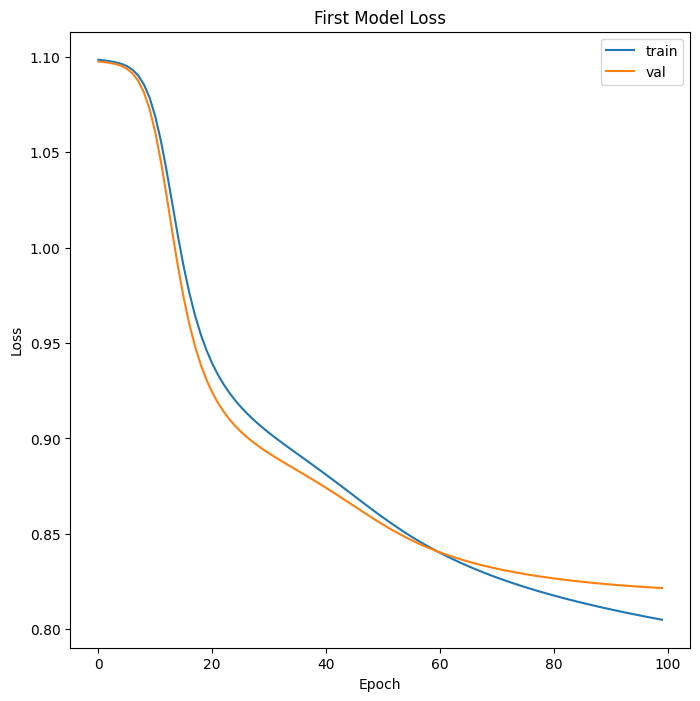

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
model = FFNN(input_dim, hidden_dim_1, hidden_dim_2, output_dim).to(device)

In [17]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

FFNN(
  (layer_1): Linear(in_features=1000, out_features=1024, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=512, out_features=3, bias=True)
)

In [18]:
#ลองทำนายจากชุดเทส
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
model.eval()
test_prediction = model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7044 



In [19]:
# Preprocess the test text
test_text = "พอใช้ได้ ตามราคาค่ะ"
preprocessed_text = remove_duplicate_chars(test_text)

# Convert preprocessed text into TF-IDF vector
tfidf_vector = tfidf_vectorizer.transform([preprocessed_text])

# Convert TF-IDF vector into PyTorch tensor
tfidf_tensor = torch.tensor(tfidf_vector.toarray())

# Move tensor to the appropriate device if GPU is available
tfidf_tensor = tfidf_tensor.to(device)

# Pass the tensor through the trained model to get the prediction
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    prediction = model(tfidf_tensor.float())

# Convert prediction to human-readable label
_, predicted_label = torch.max(prediction, 1)

# Decode the predicted label using the label encoder
predicted_sentiment = encoder.classes_[predicted_label.item()]

print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: Neutrally
